Quora question pairs dataset is available on Kaggle. 
Goal is to identify which questions asked on Quora are duplicates of questions that have already been asked.

#text similarity

In [1]:
#import libraries
import pandas as pd
import re
import string

import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
import Levenshtein
from fuzzywuzzy import fuzz
import jellyfish

import scipy
import numpy as np
from gensim import corpora

import gensim
from gensim import matutils
from sklearn.pipeline import Pipeline
import distance

In [2]:
import xgboost as xgb
from sklearn.metrics import make_scorer, matthews_corrcoef, confusion_matrix, f1_score, log_loss, roc_auc_score,\
                            plot_roc_curve, accuracy_score, roc_curve, fbeta_score, ConfusionMatrixDisplay,\
                            precision_score, classification_report, balanced_accuracy_score

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, RandomizedSearchCV,\
                                    cross_validate,cross_val_score, RepeatedStratifiedKFold
from joblib import parallel_backend
import matplotlib.pyplot as plt

from scipy.sparse import hstack
from sklearn.decomposition import TruncatedSVD


In [3]:
import warnings
warnings.filterwarnings("ignore")

pd.set_option('max_colwidth', 256)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 1000)

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
#helper func
def get_scores(y_true, y_pred_probs, thresh = 0.5):
    y_pred = [1 if i > thresh else 0 for i in y_pred_probs]
    mcc_score = matthews_corrcoef(y_true, y_pred)
    fscore = f1_score(y_true, y_pred, average='binary')
    logloss = log_loss(y_true, y_pred_probs)
    acc = accuracy_score(y_true, y_pred)
    f2 = fbeta_score(y_true, y_pred, beta=2.0, average='binary')
    print(f"The accuracy is {round(acc*100, 3)}%")
    print(f"The MCC Score is {mcc_score} ")
    print(f"The F1 Score is {fscore}")
    print(f"The F2 Score is {f2}")
    print(f"The Logloss is {logloss}")
    print("-"*50)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fpr = round(fp/(fp+tn),3)
    fnr = round((fn/(fn+tp)), 3)
    print(cm)
    print("-"*50)
    print(f"The FPR is {fpr*100}%")
    print(f"The FNR is {fnr*100}%")
    print("-"*50)

### reading data

In [6]:
questions_df = pd.read_csv('train.csv')

In [7]:
questions_df.shape

(404290, 6)

In [8]:
questions_df.sample(3)

,id,qid1,qid2,question1,question2,is_duplicate
34995,34995,64020,64021,What is mystore99.com?,What is Shortfeeds.com?,0
36414,36414,66408,66409,Is Nokia Takeover a management buyout?,Why did Nokia fail?,0
268210,268210,385717,385718,What is a bad college GPA?,Working as a produce clerk?,0


In [9]:
questions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [10]:
questions_df.duplicated().sum()

0

In [10]:
df = questions_df.sample(20000)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 120017 to 251634
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            20000 non-null  int64 
 1   qid1          20000 non-null  int64 
 2   qid2          20000 non-null  int64 
 3   question1     20000 non-null  object
 4   question2     20000 non-null  object
 5   is_duplicate  20000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 1.1+ MB


In [12]:
df['is_duplicate'].value_counts()

0    12682
1     7318
Name: is_duplicate, dtype: int64

In [13]:
(df['is_duplicate'].value_counts()/df['is_duplicate'].count())*100

0    63.41
1    36.59
Name: is_duplicate, dtype: float64

<AxesSubplot: >

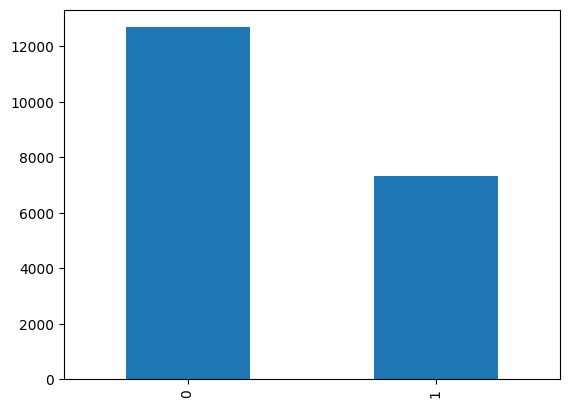

In [14]:
df['is_duplicate'].value_counts().plot(kind='bar')

In [15]:
new_df = df[['question1', 'question2', 'is_duplicate']]

In [16]:
new_df.shape

(20000, 3)

In [17]:
new_df[['question1', 'question2']].sample()

,question1,question2
254510,Which is the best 3D Printer in India and where can I buy?,What is the best 3D printer to buy in India?


In [18]:
X = new_df[['question1', 'question2']]
y = new_df[['is_duplicate']]

In [19]:
#splitting data before performing any prepsocessing etc, to avoid any data leakage
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.15, stratify = y, random_state = 42)


In [ ]:
#EDA was performed in other notebook, will share that too

In [ ]:
#nltk.download('stopwords')

In [20]:
def cleaning_text(text):
    '''Make text lowercase, remove text in quotes, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\".*?\"', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('[‘’“”…]', ' ', text)
    text = re.sub('\n', ' ', text)
    text=re.sub(r"[~.,%/:;?_&+*=—!-]",' ',text)
    
     # Replace certain special characters with their string equivalents
    text = text.replace('%', ' percent')
    text = text.replace('$', ' dollar ')
    text = text.replace('₹', ' rupee ')
    text = text.replace('€', ' euro ')
    text = text.replace('@', ' at ')
    
    return text

contraction_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"}

# Regular expression for finding contractions
contractions_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
def expand_cntractns (text,contraction_dict = contraction_dict):
    def rep(match):
        return contraction_dict[match.group(0)]
    return contractions_re.sub(rep, text)


#removing stopwords
def remove_stopwords(text):
    
    stop_words = set(stopwords.words('english'))
    cleaned_column = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    
    return cleaned_column

In [21]:
def text_preprocess(text):
    """Apply multiple cleaning functions to the text"""
    text = expand_cntractns(text)
    text = cleaning_text(text)
    return text

In [22]:
X_train['question1'] = X_train['question1'].apply(text_preprocess)
X_train['question2'] = X_train['question2'].apply(text_preprocess)

In [23]:
X_train[['question1', 'question2']].head(2)

,question1,question2
388272,what are the best resources when applying for a medicine graduate degree,what are the best resources when applying for a music graduate degree
219334,what can i use java for,what programs can java be used for


In [ ]:
#token based feats

In [24]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)


def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

In [25]:
import distance

def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features
    

In [26]:
def token_feats(df):
    
    df['len_q1'] = df['question1'].str.len() 
    df['len_q2'] = df['question2'].str.len()

    df['q1_num_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_num_words'] = df['question2'].apply(lambda row: len(row.split(" ")))
    df['common_words'] = df.apply(common_words, axis=1)
    df['word_total'] = df.apply(total_words, axis=1)
    df['word_share'] = round(df['common_words']/df['word_total'], 2)
    
    length_features = df.apply(fetch_length_features, axis=1)

    df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
    df['mean_len'] = list(map(lambda x: x[1], length_features))
    df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))
    
    return df

In [27]:
def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [28]:
def more_token_feats(df):
    token_features = df.apply(fetch_token_features, axis=1)

    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    
    return df


In [29]:
X_train = token_feats(X_train)

In [30]:
X_train = more_token_feats(X_train)

In [31]:
X_train.head(2)

,question1,question2,len_q1,len_q2,q1_num_words,q2_num_words,common_words,word_total,word_share,abs_len_diff,mean_len,longest_substr_ratio,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
388272,what are the best resources when applying for a medicine graduate degree,what are the best resources when applying for a music graduate degree,73,70,13,13,12,26,0.46,0.0,12.0,0.690141,0.833319,0.833319,0.999983,0.999983,0.916659,0.916659,1.0,1.0
219334,what can i use java for,what programs can java be used for,24,35,7,8,5,15,0.33,1.0,6.5,0.240000,0.499975,0.333322,0.749981,0.749981,0.666656,0.571420,1.0,1.0


In [32]:
X_train.shape

(17000, 20)

In [ ]:
#similarity feats

In [33]:
#func to calculate jaccard similairty
def jaccard_similarity(text1, text2):
    set1 = set(str(text1).split())
    set2 = set(str(text2).split())
    
    if len(set1.union(set2)) == 0:
        return 0
    else:
        #jaccard similarity
        return len(set1.intersection(set2)) / len(set1.union(set2))


In [34]:
def get_similairty_features(row):
    
    q1_ = row['question1']
    q2_ = row['question2']
    
    t_features = [0.0]*8
    
    q1 = remove_stopwords(q1_)
    q2 = remove_stopwords(q2_)
    
    # fuzz_ratio
    t_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    t_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    t_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    t_features[3] = fuzz.token_set_ratio(q1, q2)
    
    # levenshtein
    t_features[4] = Levenshtein.distance(str(q1), str(q2))
    
     # jarowinkler
    t_features[5] = jellyfish.jaro_winkler(str(q1), str(q2))
    
     # jaccard_set_ratio
    t_features[6] = jaccard_similarity(q1_, q2_)
    
    #wratio    
    t_features[7] = fuzz.WRatio(q1, q2)
    
    return t_features


In [35]:
def similarity_cols(df):
    
    sim_features = df.apply(get_similairty_features, axis=1)

    # Creating new feature columns for fuzzy features
    df['fuzz_ratio'] = list(map(lambda x: x[0], sim_features))
    df['fuzz_partial_ratio'] = list(map(lambda x: x[1], sim_features))
    df['token_sort_ratio'] = list(map(lambda x: x[2], sim_features))
    df['token_set_ratio'] = list(map(lambda x: x[3], sim_features))
    df['leven_dis'] = list(map(lambda x: x[4], sim_features))
    df['jaro_winkler'] = list(map(lambda x: x[5], sim_features))
    df['jaccard_sim'] = list(map(lambda x: x[6], sim_features))
    df['wratio'] = list(map(lambda x: x[7], sim_features))
    
    return df

In [36]:
new_df = similarity_cols(X_train)

In [37]:
new_df.shape

(17000, 28)

In [38]:
new_df.head(2)

,question1,question2,len_q1,len_q2,q1_num_words,q2_num_words,common_words,word_total,word_share,abs_len_diff,mean_len,longest_substr_ratio,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,leven_dis,jaro_winkler,jaccard_sim,wratio
388272,what are the best resources when applying for a medicine graduate degree,what are the best resources when applying for a music graduate degree,73,70,13,13,12,26,0.46,0.0,12.0,0.690141,0.833319,0.833319,0.999983,0.999983,0.916659,0.916659,1.0,1.0,92,89,92,93,5,0.933068,0.846154,92
219334,what can i use java for,what programs can java be used for,24,35,7,8,5,15,0.33,1.0,6.5,0.240000,0.499975,0.333322,0.749981,0.749981,0.666656,0.571420,1.0,1.0,46,75,62,67,13,0.527778,0.444444,86


In [39]:
new_df.describe()

,len_q1,len_q2,q1_num_words,q2_num_words,common_words,word_total,word_share,abs_len_diff,mean_len,longest_substr_ratio,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,leven_dis,jaro_winkler,jaccard_sim,wratio
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,58.896471,59.379294,12.699765,12.927706,5.931471,22.822765,0.271219,3.690706,10.993059,0.391651,0.589177,0.458201,0.568939,0.431822,0.556063,0.431108,0.307765,0.513118,61.977471,70.034765,64.361824,74.611176,24.050706,0.746915,0.369689,76.774471
std,29.475111,32.230883,6.337961,7.054677,3.089572,8.260150,0.117621,4.543751,4.906693,0.232345,0.313879,0.277373,0.336674,0.298335,0.267504,0.247000,0.461582,0.499843,20.603456,20.155858,19.954459,21.614604,20.290148,0.149981,0.244520,18.297856
min,1.000000,1.000000,2.000000,2.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.000000,38.000000,9.000000,9.000000,4.000000,17.000000,0.180000,1.000000,8.000000,0.212766,0.374995,0.249997,0.333322,0.199996,0.363633,0.235293,0.000000,0.000000,45.000000,54.000000,50.000000,60.000000,9.000000,0.635040,0.178571,66.000000
50%,51.000000,50.000000,11.000000,11.000000,6.000000,21.000000,0.270000,2.000000,10.000000,0.346939,0.666644,0.499975,0.599988,0.399992,0.571420,0.415227,0.000000,1.000000,61.000000,70.000000,64.000000,78.000000,19.000000,0.712715,0.333333,86.000000
75%,71.000000,71.000000,15.000000,15.000000,7.000000,27.000000,0.360000,5.000000,13.000000,0.533333,0.833319,0.666644,0.833319,0.666644,0.777769,0.615380,1.000000,1.000000,78.000000,86.000000,79.000000,94.000000,34.000000,0.885005,0.538462,88.000000
max,309.000000,334.000000,83.000000,97.000000,32.000000,90.000000,0.500000,45.000000,56.500000,0.992481,0.999993,0.999993,0.999993,0.999992,0.999995,0.999995,1.000000,1.000000,100.000000,100.000000,100.000000,100.000000,188.000000,1.000000,1.000000,100.000000


In [40]:
new_df.columns

Index(['question1', 'question2', 'len_q1', 'len_q2', 'q1_num_words',
       'q2_num_words', 'common_words', 'word_total', 'word_share',
       'abs_len_diff', 'mean_len', 'longest_substr_ratio', 'cwc_min',
       'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq',
       'first_word_eq', 'fuzz_ratio', 'fuzz_partial_ratio', 'token_sort_ratio',
       'token_set_ratio', 'leven_dis', 'jaro_winkler', 'jaccard_sim',
       'wratio'],
      dtype='object')

In [41]:
numeric_feats = ['len_q1', 'len_q2',
       'q1_num_words', 'q2_num_words', 'common_words', 'word_total',
       'word_share', 'abs_len_diff', 'mean_len', 'longest_substr_ratio',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'fuzz_ratio', 'fuzz_partial_ratio',
       'token_sort_ratio', 'token_set_ratio', 'leven_dis', 'jaro_winkler',
       'jaccard_sim', 'wratio']

In [42]:
from sklearn.preprocessing import MinMaxScaler

new_df_2 = MinMaxScaler().fit_transform(new_df[numeric_feats])

### only numeric feats

In [43]:
xgb_clf_num = xgb.XGBClassifier(max_depth=50, n_estimators=300, learning_rate=0.2, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, subsample=0.8, eval_metric = 'logloss').fit(new_df_2, y_train) 


In [45]:
X_test['question1'] = X_test['question1'].apply(text_preprocess)
X_test['question2'] = X_test['question2'].apply(text_preprocess)

#token based feats
X_test_ = token_feats(X_test)

X_test_ = more_token_feats(X_test_)

#sim based feats
X_test_ = similarity_cols(X_test)

X_test_ = MinMaxScaler().fit_transform(X_test_[numeric_feats])


In [47]:
test_probs = xgb_clf_num.predict_proba(X_test_)[:,1]
get_scores(y_test, test_probs, 0.5)

The accuracy is 72.2%
The MCC Score is 0.39268522036685577 
The F1 Score is 0.6066037735849056
The F2 Score is 0.5938308090136681
The Logloss is 0.5317060034299939
--------------------------------------------------
[[1523  379]
 [ 455  643]]
--------------------------------------------------
The FPR is 19.900000000000002%
The FNR is 41.4%
--------------------------------------------------


### only tfidf

In [49]:
tfidf_vec = TfidfVectorizer(analyzer="word", tokenizer = nltk.word_tokenize, stop_words='english', max_features=5000)
tfidf_vec.fit(pd.concat((new_df['question1'], new_df['question2'])).unique())


TfidfVectorizer(max_features=5000, stop_words='english',
                tokenizer=<function word_tokenize at 0x13cf08940>)

In [50]:
trainq1_trans = tfidf_vec.transform(new_df['question1'].values)
trainq2_trans = tfidf_vec.transform(new_df['question2'].values)


In [51]:
tfidf_w = hstack((trainq1_trans,trainq2_trans))

In [53]:
svd = TruncatedSVD(n_components=500, n_iter=20, random_state=12)
trunc_tfidf_w = svd.fit_transform(tfidf_w)

In [50]:
trunc_tfidf_w.shape

(17000, 800)

In [54]:
xgb_clf_tfidf = xgb.XGBClassifier(max_depth=50, n_estimators=300, learning_rate=0.2, colsample_bytree=.7, gamma=0, 
                            reg_alpha=4, objective='binary:logistic', eta=0.3, subsample=0.8,
                            eval_metric = 'logloss').fit(trunc_tfidf_w, y_train) 


In [55]:
#test
X_test['question1'] = X_test['question1'].apply(text_preprocess)
X_test['question2'] = X_test['question2'].apply(text_preprocess)


testq1_trans = tfidf_vec.transform(X_test['question1'].values)
testq2_trans = tfidf_vec.transform(X_test['question2'].values)

tfidf_test_ = hstack((testq1_trans, testq2_trans))

trunctest_tfidf_ = svd.fit_transform(tfidf_test_)

In [57]:
test_probs = xgb_clf_tfidf.predict_proba(trunctest_tfidf_)[:,1]
get_scores(y_test, test_probs, 0.5)

The accuracy is 61.967%
The MCC Score is 0.08247954788804163 
The F1 Score is 0.2810333963453056
The F2 Score is 0.2284367957385781
The Logloss is 0.7089732608828538
--------------------------------------------------
[[1636  266]
 [ 875  223]]
--------------------------------------------------
The FPR is 14.000000000000002%
The FNR is 79.7%
--------------------------------------------------


### numeric feats+tfidf

In [58]:
X_train_2 = np.hstack((new_df_2, trunc_tfidf_w))

In [59]:
X_train_2.shape

(17000, 526)

In [ ]:
#parameters selected based on the performance from the validation data, better is to perform cross validation

In [60]:
xgb_clf = xgb.XGBClassifier(max_depth=50, n_estimators=300, learning_rate=0.2, colsample_bytree=.7, gamma=0, 
                            reg_alpha=4, objective='binary:logistic', eta=0.3, subsample=0.8,
                            eval_metric = 'logloss').fit(X_train_2, y_train) 


In [61]:
#preparing test data
X_test['question1'] = X_test['question1'].apply(text_preprocess)
X_test['question2'] = X_test['question2'].apply(text_preprocess)

#token based feats
X_test_ = token_feats(X_test)

X_test_ = more_token_feats(X_test_)

#sim based feats
X_test_ = similarity_cols(X_test)

testq1_trans = tfidf_vec.transform(X_test['question1'].values)
testq2_trans = tfidf_vec.transform(X_test['question2'].values)

tfidf_test_w = hstack((testq1_trans, testq2_trans))

trunctest_tfidf_w = svd.fit_transform(tfidf_test_w)

X_test_ = MinMaxScaler().fit_transform(X_test_[numeric_feats])
X_test_2 = np.hstack((X_test_, trunctest_tfidf_w))


In [62]:
X_test_2.shape

(3000, 526)

In [63]:
test_probs = xgb_clf.predict_proba(X_test_2)[:,1]

In [64]:
get_scores(y_test, test_probs, 0.5)

The accuracy is 71.133%
The MCC Score is 0.3869981399664826 
The F1 Score is 0.6181657848324514
The F2 Score is 0.6301690039554118
The Logloss is 0.5342493496769785
--------------------------------------------------
[[1433  469]
 [ 397  701]]
--------------------------------------------------
The FPR is 24.7%
The FNR is 36.199999999999996%
--------------------------------------------------


### numeric feats+tfidf with ngrams

In [65]:
#ngram
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', ngram_range=(2,3), tokenizer = nltk.word_tokenize,
                                   stop_words='english',  max_features=5000)
tfidf_vect_ngram.fit(pd.concat((new_df['question1'], new_df['question2'])).unique())


trainq1_ngram = tfidf_vect_ngram.transform(new_df['question1'].values)
trainq2_ngram = tfidf_vect_ngram.transform(new_df['question2'].values)

tfidf_ngram = hstack((trainq1_ngram, trainq2_ngram))


In [66]:
svd = TruncatedSVD(n_components=500, n_iter=20, random_state=12)
trunc_tfidf_ngram = svd.fit_transform(tfidf_ngram)

In [67]:
X_ngram = np.hstack((new_df_2, trunc_tfidf_ngram))

In [68]:
xgb_model_ngram = xgb.XGBClassifier(max_depth=50, n_estimators=300, learning_rate=0.2, colsample_bytree=.7, gamma=0,
                                    reg_alpha=4, objective='binary:logistic', eta=0.3, subsample=0.8,
                                    eval_metric = 'logloss').fit(X_ngram, y_train) 


In [69]:
#test
testq1_ngram = tfidf_vect_ngram.transform(X_test['question1'].values)
testq2_ngram = tfidf_vect_ngram.transform(X_test['question2'].values)

tfidf_test_ngram = hstack((testq1_ngram, testq2_ngram))

trunctest_tfidf_ngram = svd.fit_transform(tfidf_test_ngram)

X_test_ngram = np.hstack((X_test_, trunctest_tfidf_ngram))


In [70]:
X_test_ngram.shape

(3000, 526)

In [71]:
test_probs_ngram = xgb_model_ngram.predict_proba(X_test_ngram)[:,1]

In [72]:
get_scores(y_test, test_probs_ngram, 0.5)

The accuracy is 72.133%
The MCC Score is 0.38515516711508613 
The F1 Score is 0.5937803692905733
The F2 Score is 0.570814648729447
The Logloss is 0.5379027048442415
--------------------------------------------------
[[1553  349]
 [ 487  611]]
--------------------------------------------------
The FPR is 18.3%
The FNR is 44.4%
--------------------------------------------------


### numeric feats + Character Level TF-IDF

In [75]:
#Character Level TF-IDF

tfidf_char = TfidfVectorizer(analyzer='char', ngram_range=(2,3), stop_words='english',  max_features=5000,
                             tokenizer = nltk.word_tokenize,)
tfidf_char.fit(pd.concat((new_df['question1'], new_df['question2'])).unique())

trainq1_char = tfidf_char.transform(new_df['question1'].values)
trainq2_char = tfidf_char.transform(new_df['question2'].values)

tfidf_char_ = hstack((trainq1_char, trainq2_char))



In [76]:
svd = TruncatedSVD(n_components=500, n_iter=20, random_state=12)
trunc_tfidf_char = svd.fit_transform(tfidf_char_)

In [77]:
X_char = np.hstack((new_df_2, trunc_tfidf_char))

In [78]:
xgb_model_char = xgb.XGBClassifier(max_depth=50, n_estimators=300, learning_rate=0.2, colsample_bytree=.7, 
                                   gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, subsample=0.8, 
                                   eval_metric = 'logloss').fit(X_char, y_train) 


In [79]:
#test
testq1_char = tfidf_char.transform(X_test['question1'].values)
testq2_char = tfidf_char.transform(X_test['question2'].values)

tfidf_test_char = hstack((testq1_char, testq2_char))

trunctest_tfidf_char = svd.fit_transform(tfidf_test_char)

X_test_char = np.hstack((X_test_, trunctest_tfidf_char))


In [80]:
X_test_char.shape

(3000, 526)

In [81]:
test_probs_char = xgb_model_char.predict_proba(X_test_char)[:,1]

In [82]:
get_scores(y_test, test_probs_char, 0.5)

The accuracy is 71.367%
The MCC Score is 0.374971746160201 
The F1 Score is 0.595764705882353
The F2 Score is 0.5840560989112381
The Logloss is 0.5457498975769085
--------------------------------------------------
[[1508  394]
 [ 465  633]]
--------------------------------------------------
The FPR is 20.7%
The FNR is 42.3%
--------------------------------------------------


### Based on F1 score and accuracy, out of all these models, the model with numeric feats and tfidf with words without using ngrams(2,3) but default 1 perfomed a little better than others. I chose F1 score to measure the performance because in thi sproblem I am more interested to use the model for similar pairs rather than disimilar ones.

#### To further improve the model performance we can use cross validation to tune thehyperparameters. Also, can apply feature importance to remove the extra features or include more. Since in this example, we only used part of data but can test more using more data to have better performnce as F1 score of 61.8% and 72% accuracy aren't so great but a good start though.
#### Deep learning models such as LSTM can also be tested as we have enough data.(I'll apply lstm in the future to test it further.)